In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.stats import skew
mpl.rcParams['figure.dpi'] = 200
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
import seaborn as sns

This notebook visualizes the results of the .csv file with particle positions, areas, and frame id's produced by xpeem_particle_tracking3.ipynb

In [2]:
# def removebadframes(data, movienumber):
#     """
#     This function just removes frames that are visually identified as out of focus.  See 6/16/21 entry in lab notebook
#     for which frames are identified as bad

#     data is a pandas dataframe that is is generated from trackpybatch or tackpy
#     movienumber identifies which movie is being used.
#     """

#     if movienumber == 1:
#         values = [14, 30, 32, 125, 141, 148]
#         badframes = [x - 1 for x in values]     #subtract one to account for the fact that python indexes start at 0, and in the notes I took the frame indexes started at 1
#         for value in badframes:
#             data = data[(data['frame'] != value)]
#     elif movienumber == 2:
#         values = [9, 10, 31, 94, 120, 230]
#         badframes = [x - 1 for x in values]
#         for value in badframes:
#             data = data[(data['frame'] != value)]
#         data = data[(data['frame'] > 220) | (data['frame'] < 172)]
#     elif movienumber == 3:
#         values = [269, 268]
#         badframes = [x - 1 for x in values]
#         for value in badframes:
#             data = data[(data['frame'] != value)]
#         data = data[(data['frame'] > 251) | (data['frame'] < 227)]

#     return data

def frame_to_langmuir(frame):
    """Converts frames to langmuirs for movie 3, starting at 20 L and going to 65L"""
    return frame*(45/719)+20

def get_particle_stats(df:pd.DataFrame, frames= 719):
    """This function gets the number of particles, the median size, the frame id, and the number of langmuirs of oxidation that have passed"""
    summary_stats = pd.DataFrame()
    for i in range(frames):
        frame_df = df[df.frame == i]
        if frame_df.empty:
            continue
        else:
            summary_stats = summary_stats.append([{'frequency': frame_df.shape[0], 
                                                'median_size': np.median(frame_df['area']),
                                                'frame': i,
                                                'area': frame_df['area'].sum(),
                                                'langmuir': frame_to_langmuir(i),
                                                'skewness': skew(frame_df['area'])
                                                }])

    return summary_stats



In [3]:
#Read a results file and filter out appropriate frames
particles = pd.read_csv("Results/median_8000_masked.csv") #With a minsize of 3
#particles = pd.read_csv("/Users/apple/vscode/Research/mov3_median_8000_minsize_2.csv") #with a minsize of 2

particles = particles[particles['frame'] < 182] #Exclude the beginning frames for movie 2 of
particles['frame'] = particles['frame']+450 #Re-index the frames for movie 2
particles['langmuir'] = frame_to_langmuir(particles['frame']) #Add a column converting the absolute frame number to langmuirs for the third oxidation
#print(particles.head)

<bound method NDFrame.head of         frame           y           x  area  perimeter  fraction filled  \
0         450  409.285714    7.571429     7   7.207107         1.000000   
1         450  411.214286  178.500000    14  13.656854         0.666667   
2         450  411.058824   34.588235    17  12.071068         0.809524   
3         450  411.100000  187.450000    20  16.692388         0.769231   
4         450  410.800000  229.933333    15  11.414214         0.625000   
...       ...         ...         ...   ...        ...              ...   
228656    631  364.533333   72.600000    15  13.071068         0.937500   
228657    631  364.050000  367.150000    20  16.278175         0.869565   
228658    631  364.866667   26.733333    15  14.656854         0.681818   
228659    631  362.666667  491.533333    15  11.656854         1.000000   
228660    631  362.500000  295.916667    12  11.414214         0.705882   

        frame.1  particle   langmuir  
0             0         1  48.

Get the particle densities for the upper and lower grains

In [6]:
#uppergrain = particles[particles["centroid-0"] < 560]
#lowergrain = particles[particles["centroid-0"] >= 560]

uppergrain = particles[particles["y"] < 560]
lowergrain = particles[particles["y"] >= 560]

totalstats = get_particle_stats(particles)
upperstats = get_particle_stats(uppergrain)
lowerstats = get_particle_stats(lowergrain)

In [7]:
mov2 = pd.read_csv("Results/mov2_median_8000.csv")
print(mov2.head())
#plt.scatter(mov2["centroid-1"], 1024-mov2["centroid-0"])
#filtered = mov2[mov2["frame"]> 32]
filtered = mov2[mov2["frame"]>0]
filtered = filtered[filtered["frame"]< 160]
filtered = filtered.append(mov2[mov2["frame"] >221])
filtered['frame'] = filtered['frame']+155
filtered['langmuir'] = frame_to_langmuir(filtered['frame'])
mov2stats = get_particle_stats(filtered)
uppergrainstats = get_particle_stats(filtered[filtered["centroid-0"] < 600])
lowergrainstats = get_particle_stats(filtered[filtered["centroid-0"] >= 600])


   Unnamed: 0  centroid-0  centroid-1  area  frame
0           5   96.200000  320.400000    10      0
1           9  106.800000  327.000000     5      0
2          12  138.857143  309.500000    14      0
3          32  187.600000  308.000000     5      0
4          35  190.714286  306.571429     7      0


In [8]:
# plt.scatter(mov2stats['frame'], mov2stats['frequency']/301.6)
# plt.scatter(uppergrainstats['frame'], uppergrainstats['frequency']/169.6)
# plt.scatter(lowergrainstats['frame'], lowergrainstats['frequency']/132.1)
# plt.legend(("Total","Upper Grain", "Lower Grain"))

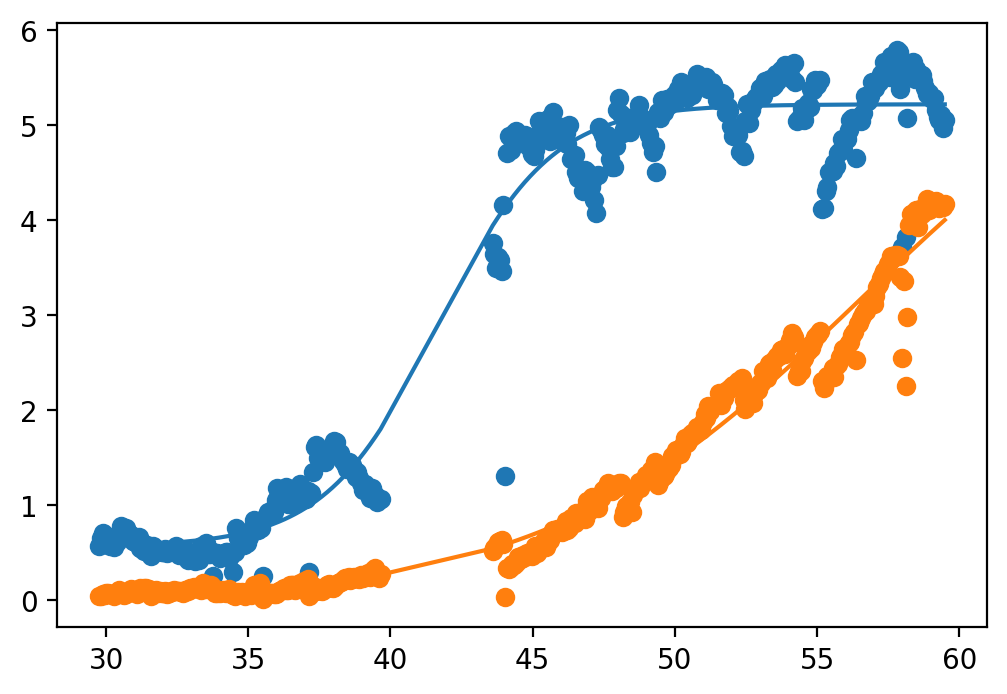

In [9]:
import scipy.optimize as opt

uppermov2 = uppergrainstats['frequency'].to_numpy()/169.6
uppermov3 = upperstats["frequency"].to_numpy()/153
lowermov2 = lowergrainstats['frequency'].to_numpy()/132.1
lowermov3 = lowerstats["frequency"].to_numpy()/186

upperlang2 = frame_to_langmuir(uppergrainstats['frame']).to_numpy()
upperlang3 = upperstats['langmuir'].to_numpy()
lowerlang2 = frame_to_langmuir(lowergrainstats["frame"]).to_numpy()
lowerlang3 = lowerstats["langmuir"].to_numpy()

upper_frequency = np.concatenate((uppermov2, uppermov3))
lower_frequency = np.concatenate((lowermov2, lowermov3))

upper_lang = np.concatenate((upperlang2, upperlang3))
lower_lang = np.concatenate((lowerlang2, lowerlang3))

def logistic(x, a, b, c, d):
    return a/(1.+np.exp(-c*(x-d)))+b

initial_guess = [6, .5, 1, 30]
popt_upper, pcov = opt.curve_fit(logistic, upper_lang, upper_frequency, initial_guess, method='trf')
popt_lower, pcov = opt.curve_fit(logistic, lower_lang, lower_frequency, initial_guess, method='trf' )

plt.plot(upper_lang, logistic(upper_lang, *popt_upper))
plt.plot(lower_lang, logistic(lower_lang, *popt_lower))
#print(upper_frequency)
plt.scatter(upper_lang, upper_frequency)
plt.scatter(lower_lang, lower_frequency)


<ipython-input-10-0723cc33d657>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  secax.set_xticklabels((timerange))


Text(0.5, 0, 'Exposure time (s)')

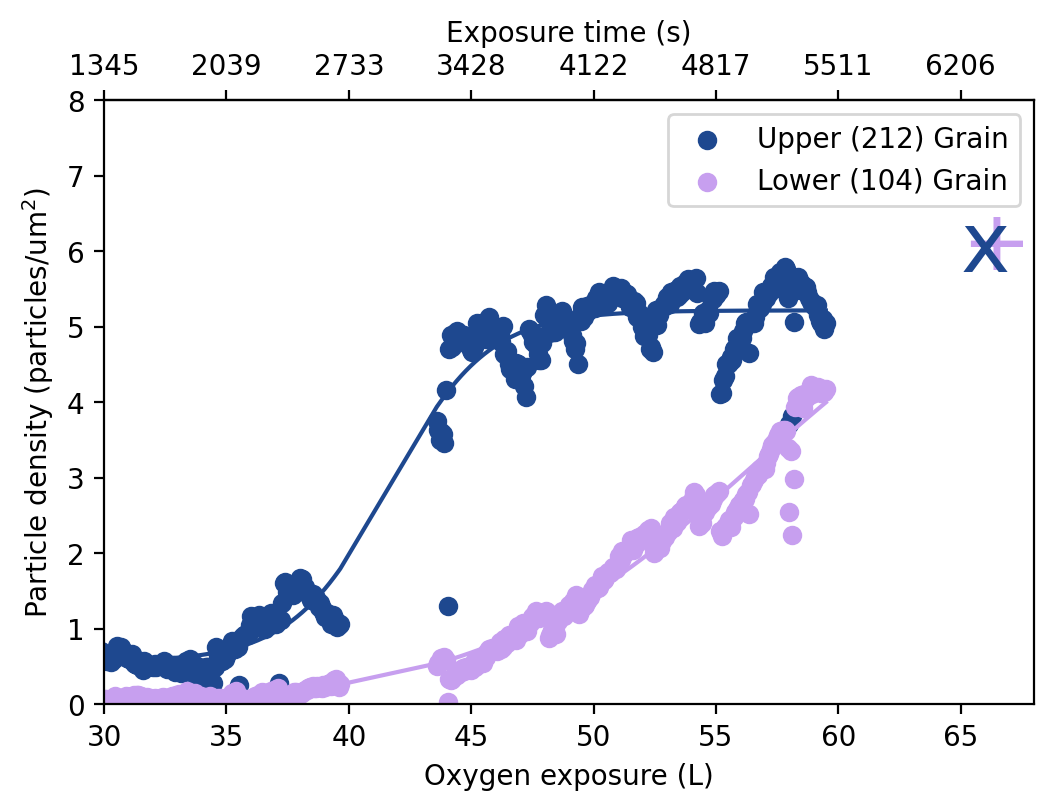

In [10]:
#plot the number of islands over time

#plt.scatter(frame_to_langmuir(mov2stats['frame']), mov2stats['frequency']/301.6,color='xkcd:coral')
fig, ax = plt.subplots()

ax.scatter(frame_to_langmuir(uppergrainstats['frame']), uppergrainstats['frequency']/169.6,color='xkcd:cobalt')
ax.scatter(frame_to_langmuir(lowergrainstats['frame']), lowergrainstats['frequency']/132.1,color='xkcd:lavender')
#plt.scatter(totalstats['langmuir'],totalstats["frequency"]/339,color='xkcd:coral')
ax.scatter(upperstats['langmuir'], upperstats["frequency"]/153,color='xkcd:cobalt')
ax.scatter(lowerstats['langmuir'], lowerstats["frequency"]/186,color='xkcd:lavender')
ax.annotate('+', (65, 5.76), color='xkcd:lavender',fontsize=30)
ax.annotate('x', (65, 5.73),color='xkcd:cobalt',fontsize=30)
#plt.annotate('+', (65, 1.94), color='xkcd:lavender',fontsize=30)
ax.legend(["Upper (212) Grain", "Lower (104) Grain"])
plt.plot(upper_lang, logistic(upper_lang, *popt_upper), color = 'xkcd:cobalt')
plt.plot(lower_lang, logistic(lower_lang, *popt_lower),color = 'xkcd:lavender')
ax.set_xlim((30,68))
ax.set_ylim((0,8))
ax.set_xlabel("Oxygen exposure (L)")
ax.set_ylabel("Particle density (particles/um$^2$)")
secax = ax.secondary_xaxis('top')
#Movie 2 starts at 1345 seconds, the oxidation ends at 6202 seconds
timerange = np.linspace(1345,6206,8,dtype=int)
secax.set_xticklabels((timerange))
secax.set_xlabel("Exposure time (s)")


Text(0, 0.5, 'Partkcle Area Skewness')

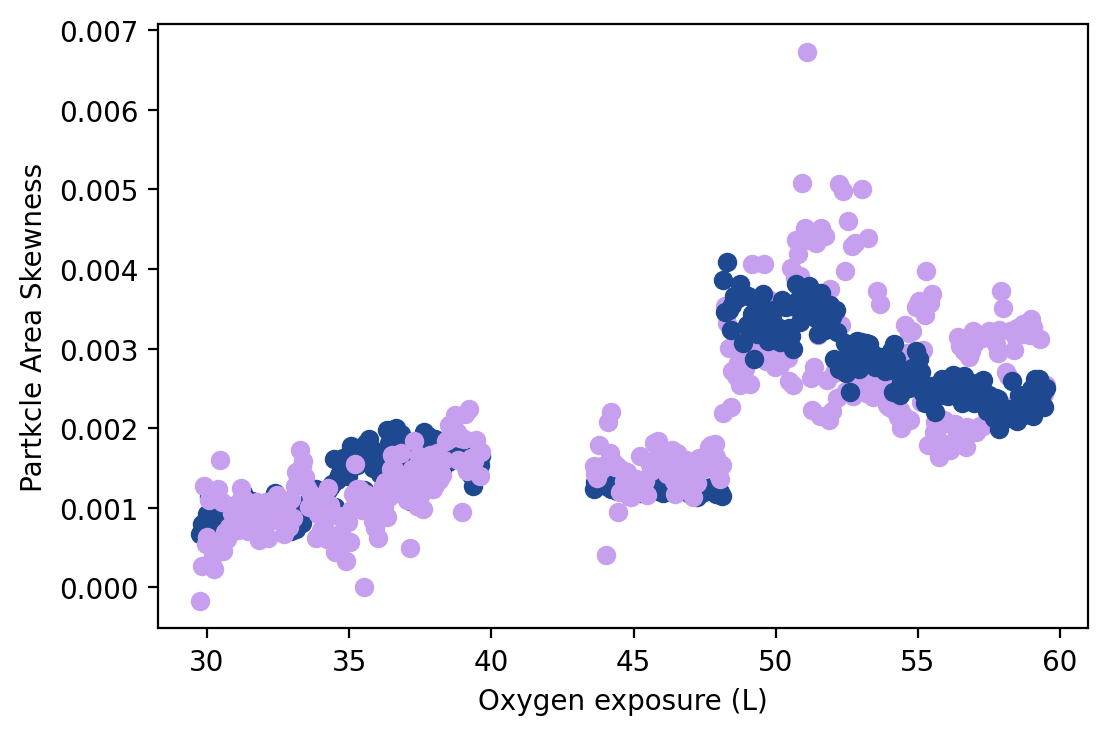

In [11]:
plt.scatter(upperlang2, uppergrainstats['skewness']*.025**2, color='xkcd:cobalt')
plt.scatter(lowerlang2, lowergrainstats['skewness']*.025**2,color='xkcd:lavender') #convert pixels to um^2 by multiplying by 0.025 um/px
plt.scatter(lowerlang3, lowerstats['skewness']*.025**2,color='xkcd:lavender')
plt.scatter(upperlang3, upperstats['skewness']*.025**2, color='xkcd:cobalt')
plt.xlabel("Oxygen exposure (L)")
plt.ylabel("Partkcle Area Skewness")

(232,)


Text(0.5, 1.0, 'Median island size')

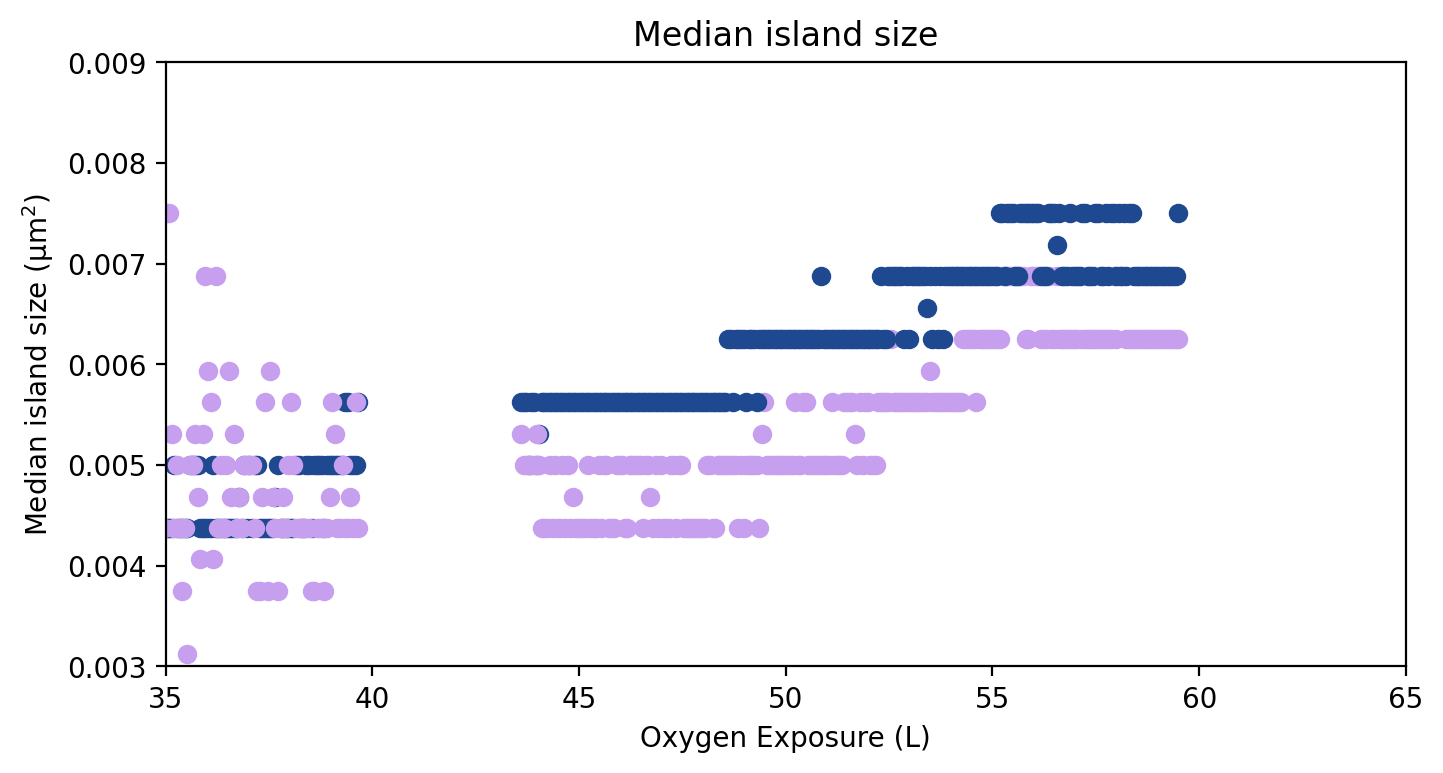

In [12]:
#plot median size over time
fig1 = plt.figure(figsize=(8,4))
print(uppergrainstats['median_size'].shape)
plt.ylabel("Median island size ($\mu$m$^2$)")
plt.xlabel("Oxygen Exposure (L)")

plt.scatter(upperlang2, uppergrainstats['median_size']*.025**2, color='xkcd:cobalt')
plt.scatter(lowerlang2, lowergrainstats['median_size']*.025**2,color='xkcd:lavender') #convert pixels to um^2 by multiplying by 0.025 um/px
plt.scatter(lowerlang3, lowerstats['median_size']*.025**2,color='xkcd:lavender')
plt.scatter(upperlang3, upperstats['median_size']*.025**2, color='xkcd:cobalt')
plt.xlim((35,65))
plt.ylim((0.003,.009))
#plt.legend(["Upper (212) grain","Lower (104) grain"])
plt.title("Median island size")

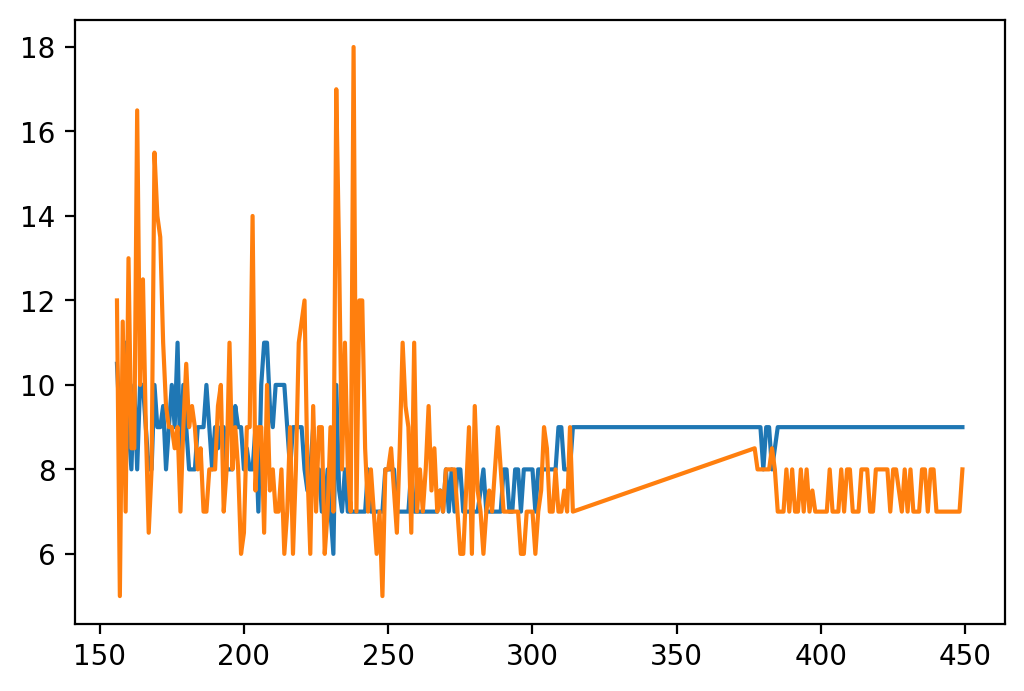

In [13]:
#plt.plot(mov2stats["frame"], mov2stats['median_size'])
plt.plot(uppergrainstats['frame'], uppergrainstats['median_size'])
plt.plot(lowergrainstats['frame'], lowergrainstats['median_size'])



In [14]:

print(frame_to_langmuir(300))
print(frame_to_langmuir(600))
frame300_upper = filtered[filtered["frame"] == 300]
frame300_upper = frame300_upper[frame300_upper["centroid-0"] >600]
frame300_lower = filtered[filtered["frame"] == 300]
frame300_lower = frame300_lower[frame300_lower["centroid-0"] <=600]

frame600 = particles[particles["frame"]==600]
print(len(frame600))
frame600_lower = frame600[frame600["y"] >= 560]
print(len(frame600_lower))
frame600_upper = frame600[frame600["y"] < 560]
print(len(frame600_upper))

# plt.scatter(frame600_lower['x'],frame600_lower['y'])
# plt.scatter(frame600_upper['x'],frame600_upper['y'])

# fig1, ax1 = plt.subplots()
# fig1 = sns.violinplot(data=[frame300_upper["area"]*.025**2,frame300_lower["area"]*0.025**2],orient="h")
# plt.title("Particle size distribution at 38.8 L")
# ax1.set_yticklabels(["Upper","Lower"])
# plt.xlim((5*.025**2,20*.025**2))
# plt.xlabel("Particle area (um^2)")

#sns.violinplot(frame300_upper['area'])
#print(np.min(particles))
# plt.plot(mov2stats["frame"], mov2stats['median_size'])
# plt.plot(uppergrainstats['frame'], uppergrainstats['median_size'])
# plt.plot(lowergrainstats['frame'], lowergrainstats['median_size'])
# plt.hist()

38.776077885952716
57.552155771905426
1506
663
843


In [15]:
# fig2, ax2 = plt.subplots()
# fig2 = sns.violinplot(data=[frame600_upper["area"]*.025**2,frame600_lower["area"]*0.025**2],orient="h")
# plt.title("Particle size distribution at 57.6 L")
# ax2.set_yticklabels(["Upper","Lower"])
# plt.xlim((5*.025**2,20*.025**2))
# plt.xlabel("Particle area (um^2)")

Text(0.5, 0, 'Particle area (um^2)')

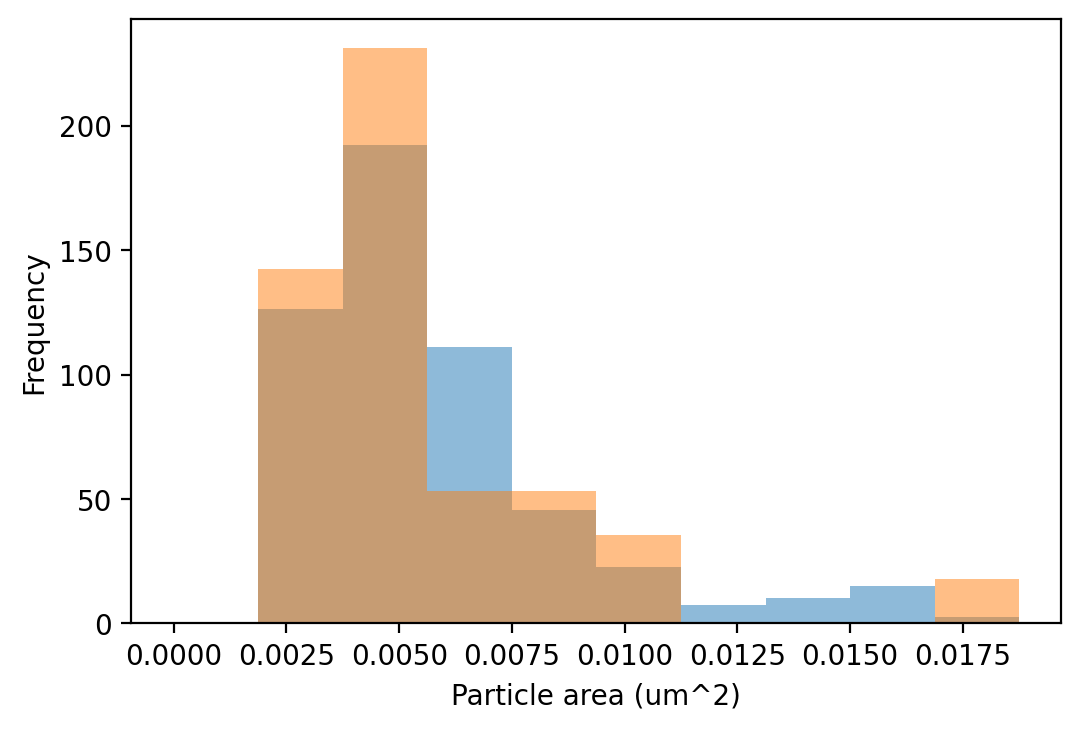

In [16]:
plt.hist(frame300_lower['area']*.025**2,density=True,alpha=0.5,range =(0,30*.025**2))
plt.hist(frame300_upper['area']*.025**2,density=True,alpha=0.5,range=(0,30*.025**2))
plt.ylabel("Frequency")
plt.xlabel("Particle area (um^2)")


Text(0.5, 0, 'Particle area (um$^2$)')

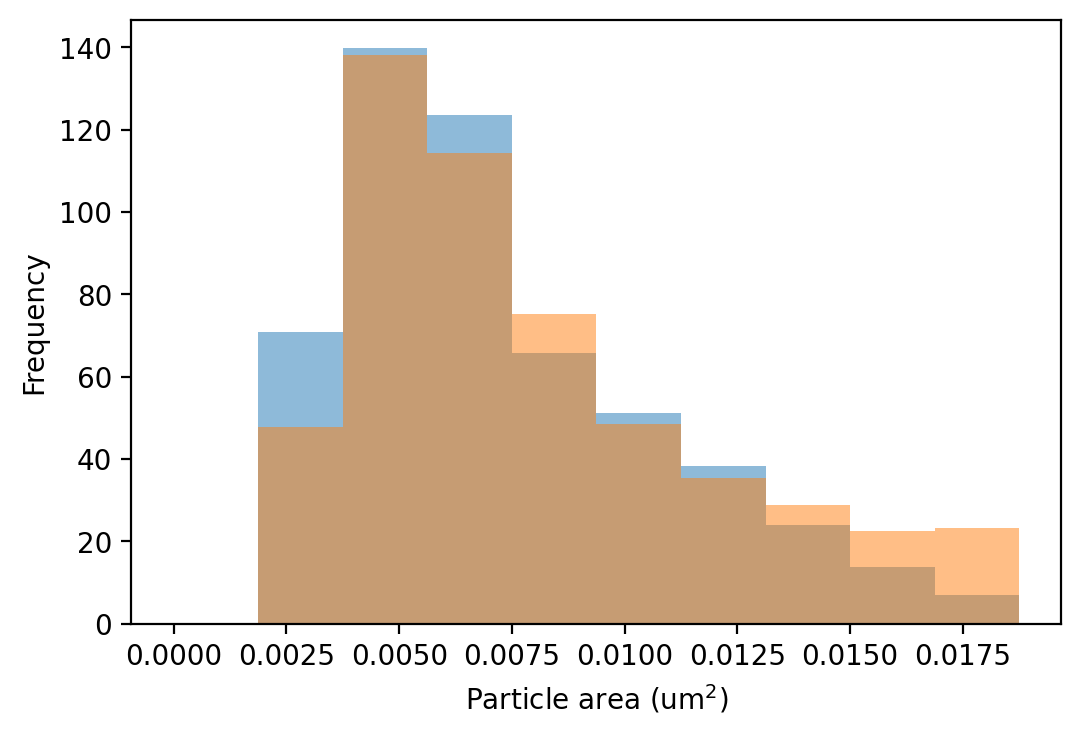

In [17]:
plt.hist(frame600_lower['area']*.025**2,density=True,alpha=0.5,range=(0,30*.025**2))
plt.hist(frame600_upper['area']*.025**2,density=True,alpha=0.5,range=(0,30*.025**2))
plt.ylabel("Frequency")
plt.xlabel("Particle area (um$^2$)")


220 663


Text(0.5, 0, 'Particle area (10$^2$ $\\mu$m$^2$)')

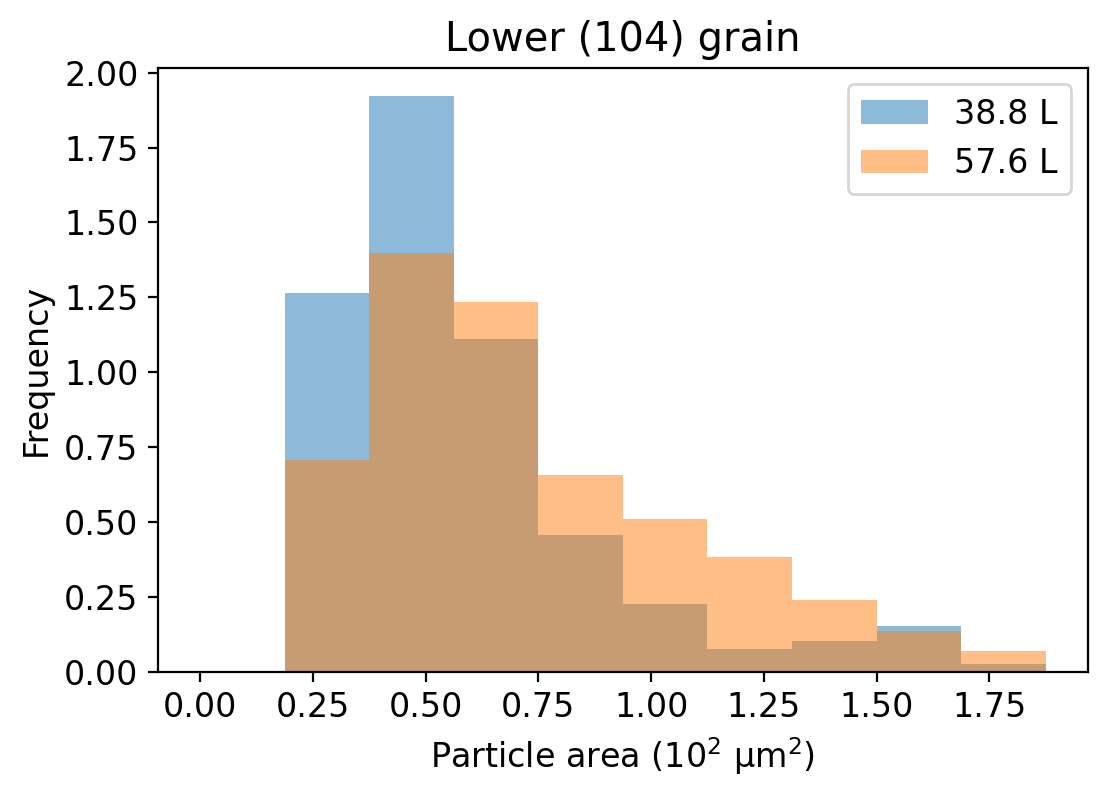

In [18]:
plt.rcParams.update({"font.size" : 12})
plt.hist(frame300_lower['area']*.025**2*100,density=True,alpha=0.5,range=(0,30*.025**2*100))
plt.hist(frame600_lower['area']*.025**2*100,density=True,alpha=0.5,range=(0,30*.025**2*100))
print(len(frame300_lower['area']),len(frame600_lower['area']))
plt.legend(["38.8 L", "57.6 L"])
plt.ylabel("Frequency")
plt.title("Lower (104) grain")
plt.xlabel("Particle area (10$^2$ $\mu$m$^2$)")

Text(0.5, 0, 'Particle area (10$^2$ $\\mu$m$^2$)')

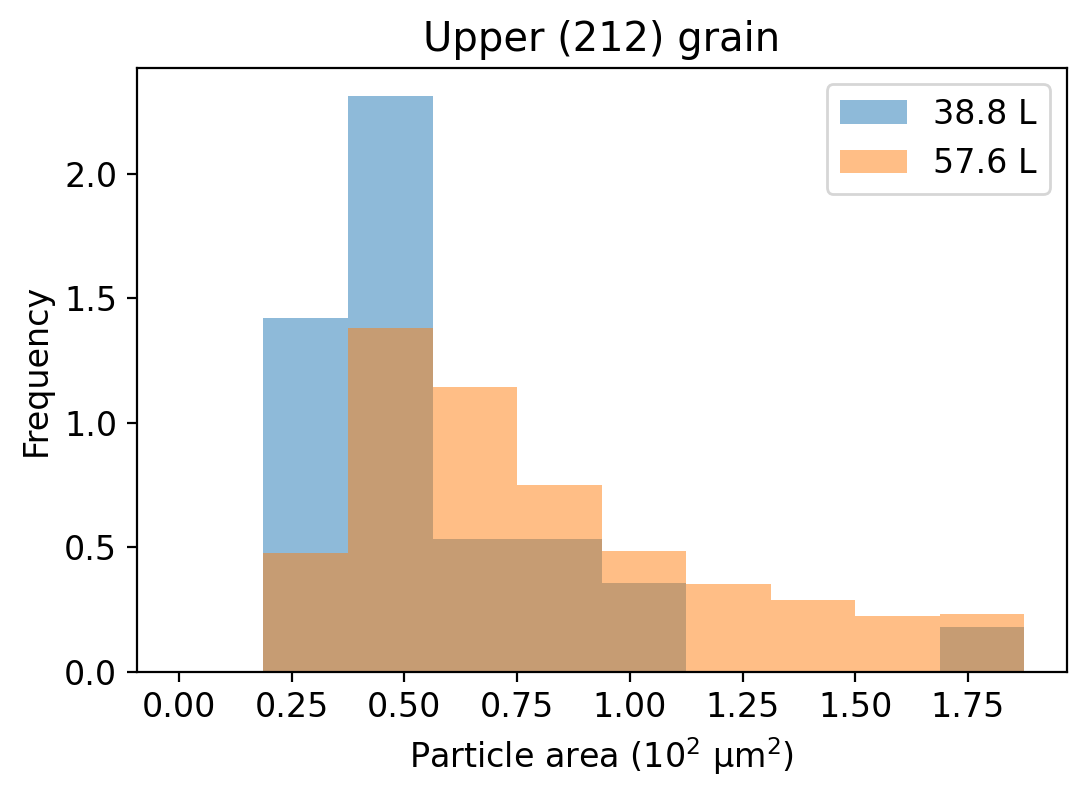

In [19]:
plt.hist(frame300_upper['area']*.025**2*100,density=True,alpha=0.5,range=(0,30*.025**2*100))
plt.hist(frame600_upper['area']*.025**2*100,density=True,alpha=0.5,range=(0,30*.025**2*100))
plt.legend(["38.8 L", "57.6 L"])
plt.title("Upper (212) grain")
plt.ylabel("Frequency")
plt.xlabel("Particle area (10$^2$ $\mu$m$^2$)")

In [20]:
# uppergrainstats = uppergrainstats.append(upperstats,ignore_index=True)
# uppergrainstats.to_csv("upper_grain_statistics.csv")
# lowergrainstats = lowergrainstats.append(lowerstats,ignore_index=True)
# lowergrainstats.to_csv("lower_grain_statistics.csv")
